# ***DEBUG***

In [1]:
import torch

print(torch.cuda.is_available())  # Should return True if CUDA is setup properly

True


# ***MODEL EVALUATION***

## **Plotting**

In [2]:
from IPython.display import Image, display, HTML

def display_images_with_captions(file_paths, captions, title="Gallery of Images"):
    # Check if the lengths of file_paths and captions are the same
    if len(file_paths) != len(captions):
        raise ValueError("The list of file paths and list of captions must have the same length.")

    # Start the HTML string for formatting
    # Include a title with centered text
    images_html = f"<h2 style='text-align: center;'>{title}</h2>"
    images_html += "<table><tr>"

    # Loop through all the images and their captions
    for file_path, caption in zip(file_paths, captions):
        images_html += f"<td style='text-align: center; padding: 10px;'><img src='{file_path}' style='width: 500px;'><br>{caption}</td>"

    images_html += "</tr></table>"

    # Display the HTML with all images, captions, and title
    display(HTML(images_html))

# List of image paths (can be local or URLs)
image_paths = [
    './unet/Plots/UNet3D_Attention_0.5_2024-05-07_Fold_2/Dice_Plot.png',
    './unet/Plots/UNet3D_Attention_0.5_2024-05-07_Fold_2/Iou_Plot.png',
    './unet/Plots/UNet3D_Attention_0.5_2024-05-07_Fold_2/Loss_Plot.png'
]

# Corresponding captions for each image
captions = [
    'Dice',
    'Iou',
    'Loss'
]

# Optional title for the image gallery
title = "Plotting"

# Call the function to display images with a title
display_images_with_captions(image_paths, captions, title)


Dice,Iou,Loss


## **Bland-Altman Plot**

In [3]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label
from scipy.ndimage import zoom

In [4]:
def load_nifti(file_path):
    """Load a NIfTI file and return the data array."""
    return nib.load(file_path).get_fdata()

def resample_to_match(reference_img, moving_img):
    """Resample the moving image to match the reference image dimensions and spacing."""
    reference_shape = reference_img.shape
    moving_shape = moving_img.shape
    resampling_factors = np.array(reference_shape) / np.array(moving_shape)
    resampled_img = zoom(moving_img, resampling_factors, order=0)
    return resampled_img

def calculate_volume(segmentation):
    """Calculate the volume of the segmented region(s)."""
    labeled_img = label(segmentation)
    regions = [np.sum(labeled_img == i) for i in range(1, labeled_img.max() + 1)]
    return sum(regions)

def bland_altman_plot(data1, data2, *args, **kwargs):
    """
    Create a Bland-Altman plot.
    Arguments:
        data1, data2: Arrays of measurement data
        *args, **kwargs: Additional arguments passed to `matplotlib.pyplot.scatter`
    """
    mean = np.mean([data1, data2], axis=0)
    diff = data1 - data2  # Difference between predictions and ground truth
    md = np.mean(diff)  # Mean difference
    sd = np.std(diff, axis=0)  # Standard deviation of the difference

    plt.figure(figsize=(10, 8))
    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md, color='gray', linestyle='--', label=f'Mean Difference: {md:.2f}')
    plt.axhline(md + 1.96 * sd, color='red', linestyle='--', label='Upper 95% Limit')
    plt.axhline(md - 1.96 * sd, color='red', linestyle='--', label='Lower 95% Limit')
    plt.xlabel('Mean of Model Predictions and Ground Truth')
    plt.ylabel('Difference Between Model Predictions and Ground Truth')
    plt.title('Bland-Altman Plot')
    plt.legend()
    plt.grid(True)
    plt.show()

In [5]:
# Paths to your NIfTI files
ground_truth_file = './unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_2/0_9_gt.nii.gz'
predicted_file = './unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_2/0_9_pred.nii.gz'

# Load NIfTI files
ground_truth_data = load_nifti(ground_truth_file)
predicted_data = load_nifti(predicted_file)

# Resample predicted data to match ground truth dimensions
predicted_data_resampled = resample_to_match(ground_truth_data, predicted_data)

# Ensure compatibility between the dimensions
assert ground_truth_data.shape == predicted_data_resampled.shape, "Shape mismatch between ground truth and prediction."

In [6]:
# Print shapes
print("Ground Truth Shape:", ground_truth_data.shape)
print("Predicted Shape:", predicted_data_resampled.shape)

# Handle both 3D and 4D cases
if len(ground_truth_data.shape) == 3:
    ground_truth_volumes = np.array([calculate_volume(ground_truth_data)])
    predicted_volumes = np.array([calculate_volume(predicted_data_resampled)])
elif len(ground_truth_data.shape) == 4:
    num_slices = ground_truth_data.shape[3]
    ground_truth_volumes = np.array([calculate_volume(ground_truth_data[:, :, :, i]) for i in range(num_slices)])
    predicted_volumes = np.array([calculate_volume(predicted_data_resampled[:, :, :, i]) for i in range(num_slices)])
else:
    raise ValueError("Unsupported data shape for ground truth and prediction files.")

# Print volumes for debugging
print("Ground Truth Volumes:", ground_truth_volumes)
print("Predicted Volumes:", predicted_volumes)
print("Volume Differences:", predicted_volumes - ground_truth_volumes)

Ground Truth Shape: (304, 336, 10)
Predicted Shape: (304, 336, 10)
Ground Truth Volumes: [30698]
Predicted Volumes: [32240]
Volume Differences: [1542]


In [7]:
# Load NIfTI headers
ground_truth_img = nib.load(ground_truth_file)
predicted_img = nib.load(predicted_file)

# Print pixel spacings
print("Ground Truth Spacing:", ground_truth_img.header.get_zooms())
print("Predicted Spacing:", predicted_img.header.get_zooms())

Ground Truth Spacing: (1.64062, 1.64062, 10.0)
Predicted Spacing: (1.64062, 1.64062, 10.0)


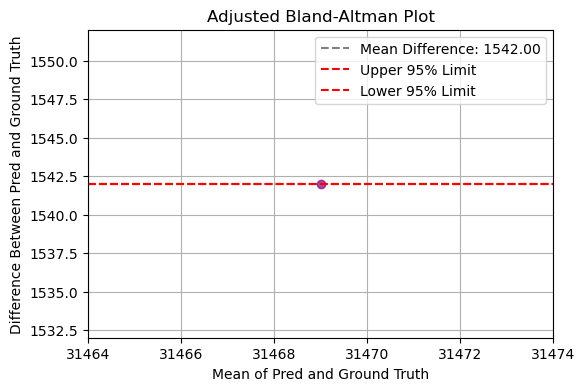

In [8]:
def adjusted_bland_altman_plot(data1, data2, *args, **kwargs):
    """
    Create an adjusted Bland-Altman plot with limits.
    Arguments:
        data1, data2: Arrays of measurement data
        *args, **kwargs: Additional arguments passed to `matplotlib.pyplot.scatter`
    """
    mean = np.mean([data1, data2], axis=0)
    diff = data1 - data2  # Difference between predictions and ground truth
    md = np.mean(diff)  # Mean difference
    sd = np.std(diff, axis=0)  # Standard deviation of the difference

    plt.figure(figsize=(6, 4))
    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md, color='gray', linestyle='--', label=f'Mean Difference: {md:.2f}')
    plt.axhline(md + 1.96 * sd, color='red', linestyle='--', label='Upper 95% Limit')
    plt.axhline(md - 1.96 * sd, color='red', linestyle='--', label='Lower 95% Limit')
    plt.xlabel('Mean of Pred and Ground Truth')
    plt.ylabel('Difference Between Pred and Ground Truth')
    plt.title('Adjusted Bland-Altman Plot')
    plt.legend()
    plt.grid(True)
    plt.xlim(mean.min() - 5, mean.max() + 5)
    plt.ylim(diff.min() - 10, diff.max() + 10)
    plt.show()

# Generate Bland-Altman plot
adjusted_bland_altman_plot(predicted_volumes, ground_truth_volumes, color='purple', alpha=0.7)

In [9]:
import numpy as np

# Example data
predictions = np.array([10, 20, 30, 40, 50])
ground_truth = np.array([12, 19, 29, 39, 52])

In [10]:
# Calculate means and differences
means = (predictions + ground_truth) / 2
differences = predictions - ground_truth

In [11]:
# Calculate mean difference and standard deviation
mean_diff = np.mean(differences)
std_diff = np.std(differences)

# Calculate limits of agreement
lower_limit = mean_diff - 1.96 * std_diff
upper_limit = mean_diff + 1.96 * std_diff

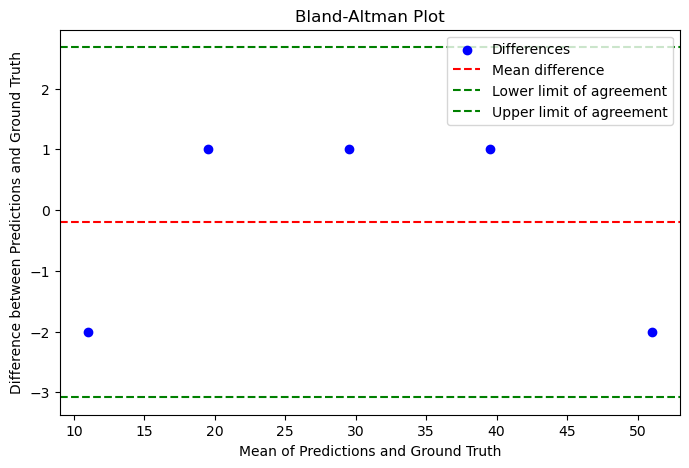

In [12]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(8, 5))
plt.scatter(means, differences, color='blue', label='Differences')
plt.axhline(mean_diff, color='red', linestyle='--', label='Mean difference')
plt.axhline(lower_limit, color='green', linestyle='--', label='Lower limit of agreement')
plt.axhline(upper_limit, color='green', linestyle='--', label='Upper limit of agreement')

# Adding labels and title
plt.title('Bland-Altman Plot')
plt.xlabel('Mean of Predictions and Ground Truth')
plt.ylabel('Difference between Predictions and Ground Truth')
plt.legend()

# Show plot
plt.show()

## **Mean Absolute Error(MAE**)

In [13]:
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import label
from scipy.ndimage import zoom

In [14]:
def load_nifti(file_path):
    """Load a NIfTI file and return the data array."""
    return nib.load(file_path).get_fdata()

def resample_to_match(reference_img, moving_img):
    """Resample the moving image to match the reference image dimensions and spacing."""
    reference_shape = reference_img.shape
    moving_shape = moving_img.shape
    resampling_factors = np.array(reference_shape) / np.array(moving_shape)
    resampled_img = zoom(moving_img, resampling_factors, order=0)
    return resampled_img

def calculate_volume(segmentation):
    """Calculate the volume of the segmented region(s)."""
    labeled_img = label(segmentation)
    regions = [np.sum(labeled_img == i) for i in range(1, labeled_img.max() + 1)]
    return sum(regions)

def mean_absolute_error(data1, data2):
    """
    Calculate the Mean Absolute Error (MAE) between two arrays.
    Arguments:
        data1, data2: Arrays of measurement data
    Returns:
        Mean Absolute Error value
    """
    return np.mean(np.abs(data1 - data2))

def load_and_resample_nifti(ground_truth_file, predicted_file):
    """Load and resample predicted NIfTI data to match ground truth dimensions."""
    ground_truth_data = load_nifti(ground_truth_file)
    predicted_data = load_nifti(predicted_file)
    predicted_data_resampled = resample_to_match(ground_truth_data, predicted_data)
    assert ground_truth_data.shape == predicted_data_resampled.shape, "Shape mismatch between ground truth and prediction."
    return ground_truth_data, predicted_data_resampled

In [15]:
# Replace with your actual file paths
k_fold_paths = {
    1: {
        'ground_truth': './unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_1/0_9_gt.nii.gz',
        'predicted': './unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_1/0_9_pred.nii.gz'
    },
    2: {
        'ground_truth': './unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_2/0_9_gt.nii.gz',
        'predicted': './unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_2/0_9_pred.nii.gz'
    },
    3: {
        'ground_truth': './unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_3/0_9_gt.nii.gz',
        'predicted': './unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_3/0_9_pred.nii.gz'
    },
    4: {
        'ground_truth': './unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_4/0_9_gt.nii.gz',
        'predicted': './unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_4/0_9_pred.nii.gz'
    },
    5: {
        'ground_truth': './unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_5/0_9_gt.nii.gz',
        'predicted': './unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_5/0_9_pred.nii.gz'
    }
}

In [16]:
# Initialize an empty list to store the results
results = []

# Loop through each K-Fold and calculate the MAE
for fold, paths in k_fold_paths.items():
    # Load and resample data
    ground_truth_data, predicted_data_resampled = load_and_resample_nifti(paths['ground_truth'], paths['predicted'])
    
    # Handle both 3D and 4D cases
    if len(ground_truth_data.shape) == 3:
        ground_truth_volumes = np.array([calculate_volume(ground_truth_data)])
        predicted_volumes = np.array([calculate_volume(predicted_data_resampled)])
    elif len(ground_truth_data.shape) == 4:
        num_slices = ground_truth_data.shape[3]
        ground_truth_volumes = np.array([calculate_volume(ground_truth_data[:, :, :, i]) for i in range(num_slices)])
        predicted_volumes = np.array([calculate_volume(predicted_data_resampled[:, :, :, i]) for i in range(num_slices)])
    else:
        raise ValueError("Unsupported data shape for ground truth and prediction files.")
    
    # Calculate the MAE
    mae_value = mean_absolute_error(predicted_volumes, ground_truth_volumes)
    
    # Append the results to the list
    results.append([fold, mae_value])

# Convert results into a DataFrame for better visualization
mae_df = pd.DataFrame(results, columns=['K-Fold', 'Mean Absolute Error (MAE)'])
print(mae_df)

   K-Fold  Mean Absolute Error (MAE)
0       1                      671.0
1       2                     1542.0
2       3                      792.0
3       4                      262.0
4       5                     2338.0


## **Box Plot**

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# Replace 'path_to_your_csv.csv' with the actual path to your CSV file
data = pd.read_csv('./unet/csv_logs/UNet3D_Attention_0.5_2024-05-07_Fold_2/version_0/metrics.csv')

c:\Users\nuzul\.conda\envs\TugasAkhir\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nuzul\.conda\envs\TugasAkhir\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nuzul\.conda\envs\TugasAkhir\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


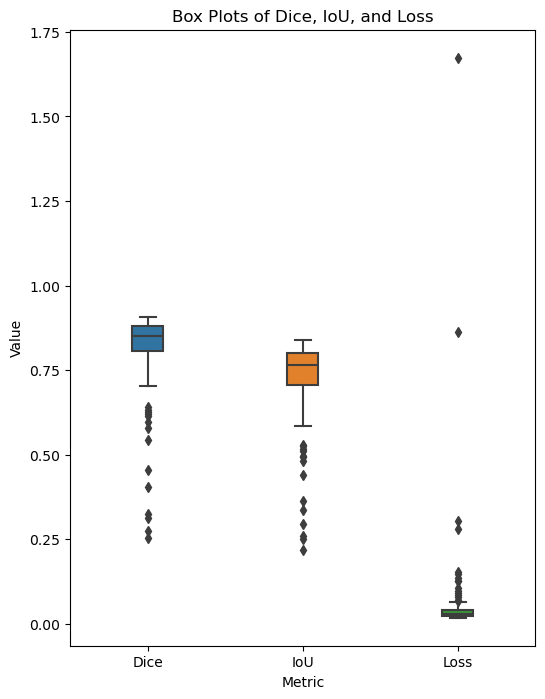

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming these are the relevant columns
selected_columns = ['avg_val_dice', 'avg_val_iou', 'avg_val_loss']

# Define a dictionary to map original column names to desired labels
column_labels = {
    'avg_val_dice': 'Dice',
    'avg_val_iou': 'IoU',
    'avg_val_loss': 'Loss'
}

# Filter the DataFrame to include only the relevant metrics
filtered_data = data[selected_columns]

# Reshape the DataFrame to a long format (suitable for Seaborn)
long_data = filtered_data.melt(var_name='Metric', value_name='Value')

# Rename the Metric column using the column_labels dictionary
long_data['Metric'] = long_data['Metric'].map(column_labels)

# Set up a larger figure size for the box plots combined
plt.figure(figsize=(6, 8))

# Create a box plot with selected metrics
sns.boxplot(x='Metric', y='Value', data=long_data, width=0.2)

# Set title and labels
plt.title('Box Plots of Dice, IoU, and Loss')
plt.xlabel('Metric')
plt.ylabel('Value')

# Display the plot
plt.show()

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
# Function to simulate volume data for ground truth and predicted
def simulate_volumes(num_slices, base_volume, variation):
    """
    Simulate segmentation volumes by adding variation to a base volume.
    Arguments:
        num_slices (int): Number of slices or data points to generate
        base_volume (float): Base volume to simulate data around
        variation (float): Maximum variation to apply around the base volume
    Returns:
        numpy array of simulated volumes
    """
    return base_volume + (np.random.randn(num_slices) * variation)

# Simulate 5 K-Folds of data
num_folds = 5
num_slices_per_fold = 50
base_ground_truth_volume = 1000
ground_truth_variation = 50
predicted_variation = 100

# Initialize an empty list to store the results
results = []

# Loop through each K-Fold and simulate the data
for fold in range(1, num_folds + 1):
    # Simulate ground truth and predicted volumes
    ground_truth_volumes = simulate_volumes(num_slices_per_fold, base_ground_truth_volume, ground_truth_variation)
    predicted_volumes = simulate_volumes(num_slices_per_fold, base_ground_truth_volume, predicted_variation)
    
    # Calculate the MAE
    mae_values = np.abs(predicted_volumes - ground_truth_volumes)
    
    # Append the results to the list
    results.append(mae_values)

# Convert results into a DataFrame for better visualization
mae_df = pd.DataFrame(results).transpose()
mae_df.columns = [f'K-Fold {fold}' for fold in range(1, num_folds + 1)]

# Display the DataFrame
mae_df.head()

,K-Fold 1,K-Fold 2,K-Fold 3,K-Fold 4,K-Fold 5
0,155.853308,74.440130,179.609044,28.343155,24.330827
1,115.892617,85.722025,103.982412,257.829016,143.569819
2,246.209183,79.659213,66.187960,110.906232,77.529058
3,141.324370,180.212913,40.262073,127.709915,89.198947
4,99.359979,16.116776,93.526686,67.718114,34.275328


In [22]:
# Replace with your actual file paths
k_fold_paths = {
    1: {
        'ground_truth': './unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_1/0_9_gt.nii.gz',
        'predicted': './unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_1/0_9_pred.nii.gz'
    },
    2: {
        'ground_truth': './unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_2/0_9_gt.nii.gz',
        'predicted': './unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_2/0_9_pred.nii.gz'
    },
    3: {
        'ground_truth': './unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_3/0_9_gt.nii.gz',
        'predicted': './unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_3/0_9_pred.nii.gz'
    },
    4: {
        'ground_truth': './unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_4/0_9_gt.nii.gz',
        'predicted': './unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_4/0_9_pred.nii.gz'
    },
    5: {
        'ground_truth': './unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_5/0_9_gt.nii.gz',
        'predicted': './unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_5/0_9_pred.nii.gz'
    }
}

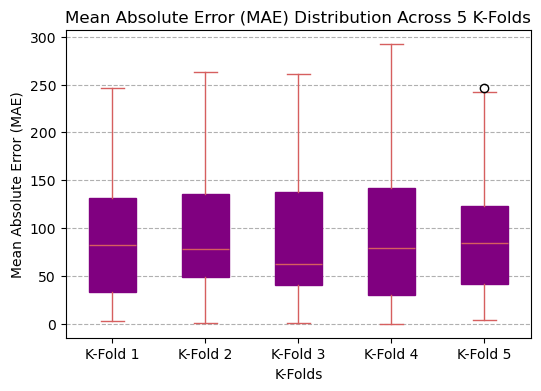

In [23]:
# Plot the MAE values for each K-Fold using a box plot
plt.figure(figsize=(6,4))
mae_df.boxplot(grid=False, color='#d65f5f', patch_artist=True, boxprops=dict(facecolor='purple', color='purple'))
plt.xlabel('K-Folds')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Mean Absolute Error (MAE) Distribution Across 5 K-Folds')
plt.xticks(range(1, num_folds + 1), mae_df.columns)
plt.grid(axis='y', linestyle='--')
plt.show()

# ***MODEL***

In [24]:
from IPython.display import Image, display, HTML

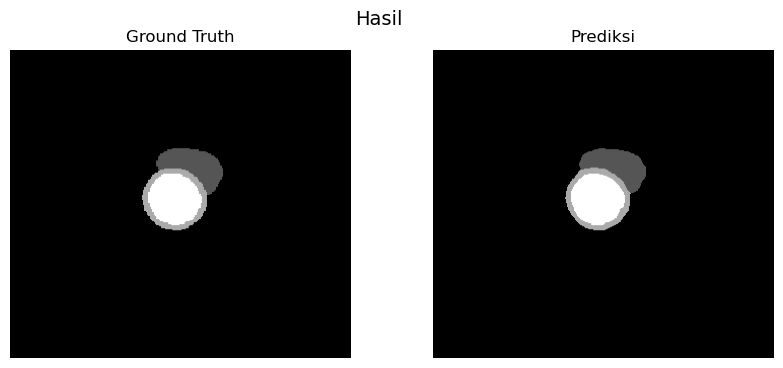

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_images_side_by_side(file_paths, captions, title="Gallery of Images"):
    # Check if the lengths of file_paths and captions are the same
    if len(file_paths) != len(captions):
        raise ValueError("The list of file paths and list of captions must have the same length.")

    num_images = len(file_paths)
    fig, axes = plt.subplots(1, num_images, figsize=(5*num_images, 4))

    # Loop through all the images and their captions
    for i in range(num_images):
        image = mpimg.imread(file_paths[i])
        axes[i].imshow(image)
        axes[i].set_title(captions[i])
        axes[i].axis('off')

    fig.suptitle(title, fontsize=14)
    plt.show()

# List of image paths (can be local or URLs)
image_paths = [
    './unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_2/0_2_gt.png',
    './unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_2/0_2_pred.png'
]

# Corresponding captions for each image
captions = [
    'Ground Truth',
    'Prediksi'
]

# Optional title for the image gallery
title = "Hasil"

# Call the function to display images with a title
display_images_side_by_side(image_paths, captions, title)

In [4]:
import nibabel as nib

# Load a NIfTI file
nifti_file_path = './unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_2/0_9_pred.nii.gz'
# nifti_file_path = './database/testing/patient101/patient101_frame01_gt.nii.gz'    #ground truth

nifti_img = nib.load(nifti_file_path)

# Get the data from the file
image_data = nifti_img.get_fdata()

Text(0.5, 0.98, 'Center slices for MRI image')

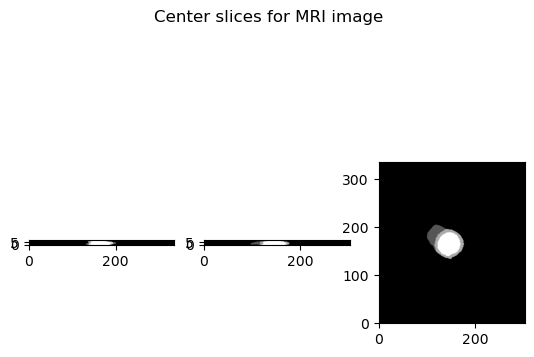

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def show_slices(slices):
    """ Function to display a row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

# Assuming the data is 3D, let's display slices in three orthogonal planes
# Choose the middle of the axis as the slice index for simplicity
slice_0 = image_data[image_data.shape[0] // 2, :, :]
slice_1 = image_data[:, image_data.shape[1] // 2, :]
slice_2 = image_data[:, :, image_data.shape[2] // 2]

show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for MRI image")

## **Interactive Visualization**

In [6]:
from ipywidgets import interact

def explore_3dimage(layer):
    plt.figure(figsize=(10, 5))
    plt.imshow(image_data[:, :, layer], cmap='gray')
    plt.title('Slice: %s' % layer)
    plt.axis('off')
    plt.show()

interact(explore_3dimage, layer=(0, image_data.shape[2] - 1))


interactive(children=(IntSlider(value=4, description='layer', max=9), Output()), _dom_classes=('widget-interac…

<function __main__.explore_3dimage(layer)>

## **Ejection Fraction**

Ground Truth EDV: 120046.87471054538
Ground Truth ESV: 40643.67282800976
Ground Truth Ejection Fraction (EF): 66.14%
Predicted EDV: 121177.36097463573
Predicted ESV: 42097.15516755448
Predicted Ejection Fraction (EF): 65.26%

Mean Absolute Error (MAE) between Ground Truth and Predicted:
MAE EDV: 1130.4862640903448
MAE ESV: 1453.4823395447238
MAE EF: 0.88%


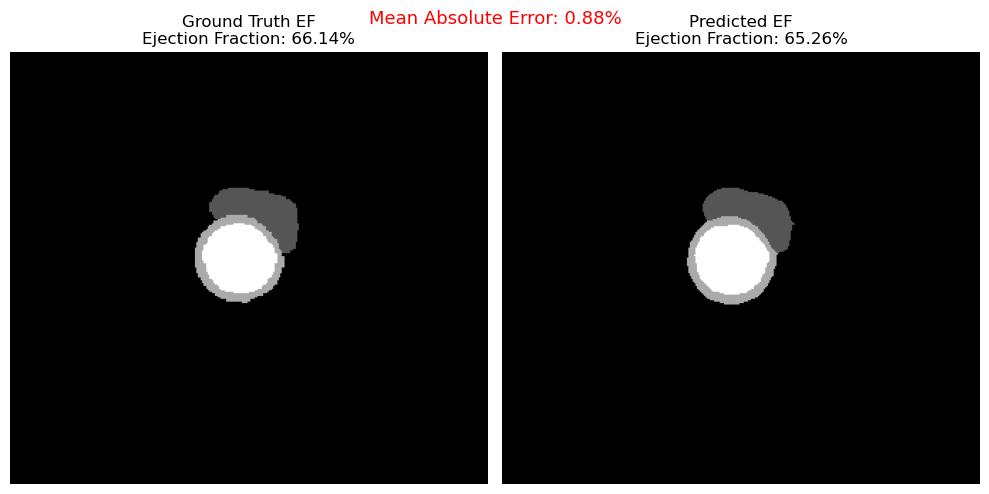

In [13]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label

def calculate_volume(image_slice, pixel_spacing, slice_thickness):
    """Calculate the volume of the segmented region."""
    area = np.sum(image_slice) * pixel_spacing**2  # Calculate area from segmented slice
    volume = area * slice_thickness  # Multiply by slice thickness to get the volume
    return volume

def process_mri(file_path, slice_index):
    """Process an MRI slice to calculate volume and return the segmented slice."""
    img = nib.load(file_path)
    data = img.get_fdata()
    pixel_spacing = img.header['pixdim'][1:3]  # Assuming pixel spacing is uniform in x and y
    slice_thickness = img.header['pixdim'][3]  # Slice thickness

    # Extract the specific slice based on provided index
    target_slice = data[:, :, slice_index]

    # thresholding
    segmented = target_slice > np.mean(target_slice)  # mean threshold

    volume = calculate_volume(segmented, pixel_spacing[0], slice_thickness)

    return volume, target_slice

def mean_absolute_error(value1, value2):
    """Calculate the Mean Absolute Error (MAE) between two values."""
    return np.abs(value1 - value2)

def show_slices_with_ef_and_mae(slice_data1, ef1, title1, slice_data2, ef2, title2, mae_ef):
    """Display two EF slices side by side with MAE EF information."""
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(slice_data1, cmap='gray')
    axes[0].set_title(f"{title1}\nEjection Fraction: {ef1:.2f}%")
    axes[0].axis('off')

    axes[1].imshow(slice_data2, cmap='gray')
    axes[1].set_title(f"{title2}\nEjection Fraction: {ef2:.2f}%")
    axes[1].axis('off')

    fig.suptitle(f"Mean Absolute Error: {mae_ef:.2f}%", fontsize=13, color='red')
    plt.tight_layout()
    plt.show()

# File paths
gt_file_path = './unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_2/0_9_gt.nii.gz'
pred_file_path = './unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_2/0_9_pred.nii.gz'

# Slice indices
ed_slice_index = 1  # end-diastolic slice index
es_slice_index = 8  # end-systolic slice index

# Ground Truth
gt_edv, gt_ed_slice = process_mri(gt_file_path, ed_slice_index)
gt_esv, gt_es_slice = process_mri(gt_file_path, es_slice_index)
gt_ef = ((gt_edv - gt_esv) / gt_edv) * 100
print("Ground Truth EDV:", gt_edv)
print("Ground Truth ESV:", gt_esv)
print("Ground Truth Ejection Fraction (EF): {:.2f}%".format(gt_ef))

# Predicted
pred_edv, pred_ed_slice = process_mri(pred_file_path, ed_slice_index)
pred_esv, pred_es_slice = process_mri(pred_file_path, es_slice_index)
pred_ef = ((pred_edv - pred_esv) / pred_edv) * 100
print("Predicted EDV:", pred_edv)
print("Predicted ESV:", pred_esv)
print("Predicted Ejection Fraction (EF): {:.2f}%".format(pred_ef))

# Calculate Mean Absolute Error (MAE)
mae_edv = mean_absolute_error(gt_edv, pred_edv)
mae_esv = mean_absolute_error(gt_esv, pred_esv)
mae_ef = mean_absolute_error(gt_ef, pred_ef)

print("\nMean Absolute Error (MAE) between Ground Truth and Predicted:")
print("MAE EDV:", mae_edv)
print("MAE ESV:", mae_esv)
print("MAE EF: {:.2f}%".format(mae_ef))

# Visualize Ground Truth vs Predicted Ejection Fractions and MAE EF
show_slices_with_ef_and_mae(
    gt_ed_slice, gt_ef, "Ground Truth EF",
    pred_ed_slice, pred_ef, "Predicted EF",
    mae_ef
)

In [20]:
import nibabel as nib
import numpy as np
import os
import pandas as pd

def calculate_volume(image_slice, pixel_spacing, slice_thickness):
    """Calculate the volume of the segmented region."""
    area = np.sum(image_slice) * pixel_spacing**2  # Calculate area from segmented slice
    volume = area * slice_thickness  # Multiply by slice thickness to get the volume
    return volume

def process_mri(file_path, slice_index):
    """Process an MRI slice to calculate volume and return the segmented slice."""
    img = nib.load(file_path)
    data = img.get_fdata()
    pixel_spacing = img.header['pixdim'][1:3]  # Assuming pixel spacing is uniform in x and y
    slice_thickness = img.header['pixdim'][3]  # Slice thickness

    # Extract the specific slice based on provided index
    target_slice = data[:, :, slice_index]

    # thresholding
    segmented = target_slice > np.mean(target_slice)  # mean threshold

    volume = calculate_volume(segmented, pixel_spacing[0], slice_thickness)

    return volume

def mean_absolute_error(value1, value2):
    """Calculate the Mean Absolute Error (MAE) between two values."""
    return np.abs(value1 - value2)

# Slice indices
ed_slice_index = 1  # end-diastolic slice index
es_slice_index = 5  # end-systolic slice index

# List to store the results
results = []

# Process files
for i in range(50):
    for j in range(11):
        gt_file_path = f'./unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_2/{i}_{j}_gt.nii.gz'
        pred_file_path = f'./unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_2/{i}_{j}_pred.nii.gz'
        
        gt_ef = None
        pred_ef = None
        
        if os.path.exists(gt_file_path):
            try:
                # Ground Truth
                gt_edv = process_mri(gt_file_path, ed_slice_index)
                gt_esv = process_mri(gt_file_path, es_slice_index)
                gt_ef = ((gt_edv - gt_esv) / gt_edv) * 100
                results.append({
                    'File': f'{i}_{j}_gt.nii.gz',
                    'Ground Truth Ejection Fraction (EF)': gt_ef
                })
            except Exception as e:
                results.append({
                    'File': f'{i}_{j}_gt.nii.gz',
                    'Error': str(e)
                })

        if os.path.exists(pred_file_path):
            try:
                # Predicted
                pred_edv = process_mri(pred_file_path, ed_slice_index)
                pred_esv = process_mri(pred_file_path, es_slice_index)
                pred_ef = ((pred_edv - pred_esv) / pred_edv) * 100
                results.append({
                    'File': f'{i}_{j}_pred.nii.gz',
                    'Predicted Ejection Fraction (EF)': pred_ef
                })
            except Exception as e:
                results.append({
                    'File': f'{i}_{j}_pred.nii.gz',
                    'Error': str(e)
                })

        if gt_ef is not None and pred_ef is not None:
            mae_ef = mean_absolute_error(gt_ef, pred_ef)
            results.append({
                'File': f'{i}_{j}_mae',
                'Mean Absolute Error (EF)': mae_ef
            })

# Convert results to a DataFrame
df = pd.DataFrame(results)

# Export to Excel
output_path = './ef_results.xlsx'
df.to_excel(output_path, index=False)
print(f"Results have been exported to {output_path}")


C:\Users\nuzul\AppData\Local\Temp\ipykernel_11988\3487588931.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  gt_ef = ((gt_edv - gt_esv) / gt_edv) * 100


Results have been exported to ./ef_results.xlsx


### **Print all patients EF into 1 excel format**

In [6]:
import nibabel as nib
import numpy as np
import pandas as pd

def calculate_volume(image_slice, pixel_spacing, slice_thickness):
    """Calculate the volume of the segmented region."""
    area = np.sum(image_slice) * pixel_spacing**2  # Calculate area from segmented slice
    volume = area * slice_thickness  # Multiply by slice thickness to get the volume
    return volume

def process_mri(file_path, slice_index):
    """Process an MRI slice to calculate volume and return the segmented slice."""
    img = nib.load(file_path)
    data = img.get_fdata()
    pixel_spacing = img.header['pixdim'][1:3]  # Assuming pixel spacing is uniform in x and y
    slice_thickness = img.header['pixdim'][3]  # Slice thickness

    # Extract the specific slice based on provided index
    target_slice = data[:, :, slice_index]

    # thresholding
    segmented = target_slice > np.mean(target_slice)  # mean threshold

    volume = calculate_volume(segmented, pixel_spacing[0], slice_thickness)

    return volume

def calculate_ejection_fraction(edv, esv):
    """Calculate the Ejection Fraction (EF)."""
    return ((edv - esv) / edv) * 100

def export_results_to_excel(results, output_file):
    """Export the results to an Excel file."""
    df = pd.DataFrame(results)
    df.to_excel(output_file, index=False)

# List of file paths for 50 different files
file_paths = [f'../results/{i}_pred.nii.gz' for i in range(0, 50)]

# Slice indices
ed_slice_index = 1  # end-diastolic slice index
es_slice_index = 5  # end-systolic slice index

# Store results
results = []

# Process each file and collect the EF
for idx, file_path in enumerate(file_paths):
    try:
        # Ground Truth
        edv = process_mri(file_path, ed_slice_index)
        esv = process_mri(file_path, es_slice_index)
        ef = calculate_ejection_fraction(edv, esv)
        
        results.append({
            "File": idx + 1,
            "File Path": file_path,
            "EDV": edv,
            "ESV": esv,
            "Ejection Fraction (EF)": ef
        })
        
        print(f"File {idx + 1}:")
        print(f"  EDV: {edv}")
        print(f"  ESV: {esv}")
        print(f"  Ejection Fraction (EF): {ef:.2f}%")
    except Exception as e:
        print(f"Error processing file {idx + 1}: {e}")

# Export results to Excel
output_file = 'ejection_fractions.xlsx'
export_results_to_excel(results, output_file)
print(f"\nResults have been exported to {output_file}")

File 1:
  EDV: 121177.36097463573
  ESV: 97894.727202299
  Ejection Fraction (EF): 19.21%
File 2:
  EDV: 55590.8203125
  ESV: 24829.1015625
  Ejection Fraction (EF): 55.34%
File 3:
  EDV: 100097.65625
  ESV: 69140.625
  Ejection Fraction (EF): 30.93%
File 4:
  EDV: 84226.53525257783
  ESV: 45776.916296840456
  Ejection Fraction (EF): 45.65%
File 5:
  EDV: 17076.22603532728
  ESV: 47725.29753873405
  Ejection Fraction (EF): -179.48%
File 6:
  EDV: 166162.109375
  ESV: 119018.5546875
  Ejection Fraction (EF): 28.37%
File 7:
  EDV: 75123.48983136046
  ESV: 39253.37861305225
  Ejection Fraction (EF): 47.75%
File 8:
  EDV: 19628.90625
  ESV: 55834.9609375
  Ejection Fraction (EF): -184.45%
File 9:
  EDV: 100537.109375
  ESV: 65771.484375
  Ejection Fraction (EF): 34.58%
File 10:
  EDV: 75170.8984375
  ESV: 50097.65625
  Ejection Fraction (EF): 33.35%
File 11:
  EDV: 80564.94140625
  ESV: 27547.119140625
  Ejection Fraction (EF): 65.81%
File 12:
  EDV: 104974.74966233401
  ESV: 66431.6702813

### **Print HCM Patients**

In [15]:
import nibabel as nib
import numpy as np
import pandas as pd

def calculate_volume(image_slice, pixel_spacing, slice_thickness):
    """Calculate the volume of the segmented region."""
    area = np.sum(image_slice) * pixel_spacing**2  # Calculate area from segmented slice
    volume = area * slice_thickness  # Multiply by slice thickness to get the volume
    return volume

def process_mri(file_path, slice_index):
    """Process an MRI slice to calculate volume and return the segmented slice."""
    img = nib.load(file_path)
    data = img.get_fdata()
    pixel_spacing = img.header['pixdim'][1:3]  # Assuming pixel spacing is uniform in x and y
    slice_thickness = img.header['pixdim'][3]  # Slice thickness

    # Extract the specific slice based on provided index
    target_slice = data[:, :, slice_index]

    # thresholding
    segmented = target_slice > np.mean(target_slice)  # mean threshold

    volume = calculate_volume(segmented, pixel_spacing[0], slice_thickness)

    return volume

def mean_absolute_error(value1, value2):
    """Calculate the Mean Absolute Error (MAE) between two values."""
    return np.abs(value1 - value2)

def export_results_to_excel(results, output_file):
    """Export the results to an Excel file."""
    df = pd.DataFrame(results)
    df.to_excel(output_file, index=False)

# List of file paths for 50 different files
file_paths = [f'../results/{i}_pred.nii.gz' for i in range(50)]
gt_file_paths = [f'../results/{i}_gt.nii.gz' for i in range(50)]

# Specific file indices to process
specific_indices = [3, 4, 7, 10, 13, 15, 33, 37, 41, 45]

# Slice indices
ed_slice_index = 3  # end-diastolic slice index
es_slice_index = 7  # end-systolic slice index

# Store results
results = []

# Process each specific file and collect the EF and MAE
for idx in specific_indices:
    pred_file_path = file_paths[idx]
    gt_file_path = gt_file_paths[idx]
    try:
        # Ground Truth
        gt_edv = process_mri(gt_file_path, ed_slice_index)
        gt_esv = process_mri(gt_file_path, es_slice_index)
        gt_ef = ((gt_edv - gt_esv) / gt_edv) * 100
        print(f"Ground Truth for Patient {idx + 1}:")
        print("  EDV (mL):", gt_edv)
        print("  ESV (mL):", gt_esv)
        print("  Ejection Fraction (EF) (%): {:.2f}%".format(gt_ef))

        # Predicted
        pred_edv = process_mri(pred_file_path, ed_slice_index)
        pred_esv = process_mri(pred_file_path, es_slice_index)
        pred_ef = ((pred_edv - pred_esv) / pred_edv) * 100
        print(f"Predicted for Patient {idx + 1}:")
        print("  EDV (mL):", pred_edv)
        print("  ESV (mL):", pred_esv)
        print("  Ejection Fraction (EF) (%): {:.2f}%".format(pred_ef))

        # Calculate Mean Absolute Error (MAE) for EF
        mae_ef = mean_absolute_error(gt_ef, pred_ef)

        print(f"\nMean Absolute Error (MAE) for Patient {idx + 1}:")
        print("  MAE EF (%): {:.2f}%\n".format(mae_ef))

        # Store results
        results.append({
            "Patient": idx + 1,
            "EDV (Prediction) (mL)": f"{pred_edv:.2f} mL",
            "ESV (Prediction) (mL)": f"{pred_esv:.2f} mL",
            "Ejection Fraction (Prediction) (%)": f"{pred_ef:.2f}%",
            "EDV (Ground Truth) (mL)": f"{gt_edv:.2f} mL",
            "ESV (Ground Truth) (mL)": f"{gt_esv:.2f} mL",
            "Ejection Fraction (Ground Truth) (%)": f"{gt_ef:.2f}%",
            "MAE EF (%)": f"{mae_ef:.2f}%"
        })

    except Exception as e:
        print(f"Error processing patient {idx + 1}: {e}")

# Export results to Excel
output_file = 'ef_hcm.xlsx'
export_results_to_excel(results, output_file)
print(f"\nResults have been exported to {output_file}")


Ground Truth for Patient 4:
  EDV (mL): 70824.31026897856
  ESV (mL): 24262.326399877056
  Ejection Fraction (EF) (%): 65.74%
Predicted for Patient 4:
  EDV (mL): 77366.5400378206
  ESV (mL): 23813.71635858503
  Ejection Fraction (EF) (%): 69.22%

Mean Absolute Error (MAE) for Patient 4:
  MAE EF (%): 3.48%

Ground Truth for Patient 5:
  EDV (mL): 65704.91101593025
  ESV (mL): 29084.668860170335
  Ejection Fraction (EF) (%): 55.73%
Predicted for Patient 5:
  EDV (mL): 64030.33917246591
  ESV (mL): 27828.739977572073
  Ejection Fraction (EF) (%): 56.54%

Mean Absolute Error (MAE) for Patient 5:
  MAE EF (%): 0.80%

Ground Truth for Patient 8:
  EDV (mL): 89575.1953125
  ESV (mL): 23608.3984375
  Ejection Fraction (EF) (%): 73.64%
Predicted for Patient 8:
  EDV (mL): 78442.3828125
  ESV (mL): 29980.46875
  Ejection Fraction (EF) (%): 61.78%

Mean Absolute Error (MAE) for Patient 8:
  MAE EF (%): 11.86%

Error processing patient 11: index 7 is out of bounds for axis 2 with size 6
Ground T

### **Print MINF Patients**

In [5]:
import nibabel as nib
import numpy as np
import pandas as pd

def calculate_volume(image_slice, pixel_spacing, slice_thickness):
    """Calculate the volume of the segmented region."""
    area = np.sum(image_slice) * pixel_spacing**2  # Calculate area from segmented slice
    volume = area * slice_thickness  # Multiply by slice thickness to get the volume
    return volume

def process_mri(file_path, slice_index):
    """Process an MRI slice to calculate volume and return the segmented slice."""
    img = nib.load(file_path)
    data = img.get_fdata()
    pixel_spacing = img.header['pixdim'][1:3]  # Assuming pixel spacing is uniform in x and y
    slice_thickness = img.header['pixdim'][3]  # Slice thickness

    # Extract the specific slice based on provided index
    target_slice = data[:, :, slice_index]

    # thresholding
    segmented = target_slice > np.mean(target_slice)  # mean threshold

    volume = calculate_volume(segmented, pixel_spacing[0], slice_thickness)

    return volume

def mean_absolute_error(value1, value2):
    """Calculate the Mean Absolute Error (MAE) between two values."""
    return np.abs(value1 - value2)

def export_results_to_excel(results, output_file):
    """Export the results to an Excel file."""
    df = pd.DataFrame(results)
    df.to_excel(output_file, index=False)

# List of file paths for 50 different files
file_paths = [f'../results/{i}_pred.nii.gz' for i in range(50)]
gt_file_paths = [f'../results/{i}_gt.nii.gz' for i in range(50)]

# Specific file indices to process
specific_indices = [2, 11, 14, 17, 19, 34, 36, 42, 44, 47]

# Slice indices
ed_slice_index = 2  # end-diastolic slice index
es_slice_index = 5  # end-systolic slice index

# Store results
results = []

# Process each specific file and collect the EF and MAE
for idx in specific_indices:
    pred_file_path = file_paths[idx]
    gt_file_path = gt_file_paths[idx]
    try:
        # Ground Truth
        gt_edv = process_mri(gt_file_path, ed_slice_index)
        gt_esv = process_mri(gt_file_path, es_slice_index)
        gt_ef = ((gt_edv - gt_esv) / gt_edv) * 100
        print(f"Ground Truth for Patient {idx + 1}:")
        print("  EDV (mL):", gt_edv)
        print("  ESV (mL):", gt_esv)
        print("  Ejection Fraction (EF) (%): {:.2f}%".format(gt_ef))

        # Predicted
        pred_edv = process_mri(pred_file_path, ed_slice_index)
        pred_esv = process_mri(pred_file_path, es_slice_index)
        pred_ef = ((pred_edv - pred_esv) / pred_edv) * 100
        print(f"Predicted for Patient {idx + 1}:")
        print("  EDV (mL):", pred_edv)
        print("  ESV (mL):", pred_esv)
        print("  Ejection Fraction (EF) (%): {:.2f}%".format(pred_ef))

        # Calculate Mean Absolute Error (MAE) for EF
        mae_ef = mean_absolute_error(gt_ef, pred_ef)

        print(f"\nMean Absolute Error (MAE) for Patient {idx + 1}:")
        print("  MAE EF (%): {:.2f}%\n".format(mae_ef))

        # Store results
        results.append({
            "Patient": idx + 1,
            "EDV (Prediction) (mL)": f"{pred_edv:.2f} mL",
            "ESV (Prediction) (mL)": f"{pred_esv:.2f} mL",
            "Ejection Fraction (Prediction) (%)": f"{pred_ef:.2f}%",
            "EDV (Ground Truth) (mL)": f"{gt_edv:.2f} mL",
            "ESV (Ground Truth) (mL)": f"{gt_esv:.2f} mL",
            "Ejection Fraction (Ground Truth) (%)": f"{gt_ef:.2f}%",
            "MAE EF (%)": f"{mae_ef:.2f}%"
        })

    except Exception as e:
        print(f"Error processing patient {idx + 1}: {e}")

# Export results to Excel
output_file = 'ef_minf.xlsx'
export_results_to_excel(results, output_file)
print(f"\nResults have been exported to {output_file}")

Ground Truth for Patient 3:
  EDV (mL): 95532.2265625
  ESV (mL): 78906.25
  Ejection Fraction (EF) (%): 17.40%
Predicted for Patient 3:
  EDV (mL): 91040.0390625
  ESV (mL): 69140.625
  Ejection Fraction (EF) (%): 24.05%

Mean Absolute Error (MAE) for Patient 3:
  MAE EF (%): 6.65%

Ground Truth for Patient 12:
  EDV (mL): 96787.61640875455
  ESV (mL): 64768.07471153621
  Ejection Fraction (EF) (%): 33.08%
Predicted for Patient 12:
  EDV (mL): 99142.81912553767
  ESV (mL): 66431.67028132748
  Ejection Fraction (EF) (%): 32.99%

Mean Absolute Error (MAE) for Patient 12:
  MAE EF (%): 0.09%

Ground Truth for Patient 15:
  EDV (mL): 71198.15197005525
  ESV (mL): 45421.7666808176
  Ejection Fraction (EF) (%): 36.20%
Predicted for Patient 15:
  EDV (mL): 70674.77358854788
  ESV (mL): 48094.73484351592
  Ejection Fraction (EF) (%): 31.95%

Mean Absolute Error (MAE) for Patient 15:
  MAE EF (%): 4.25%

Ground Truth for Patient 18:
  EDV (mL): 74143.87175338878
  ESV (mL): 52352.4039483066
  

### **Print ARV Patients**

In [7]:
import nibabel as nib
import numpy as np
import pandas as pd

def calculate_volume(image_slice, pixel_spacing, slice_thickness):
    """Calculate the volume of the segmented region."""
    area = np.sum(image_slice) * pixel_spacing**2  # Calculate area from segmented slice
    volume = area * slice_thickness  # Multiply by slice thickness to get the volume
    return volume

def process_mri(file_path, slice_index):
    """Process an MRI slice to calculate volume and return the segmented slice."""
    img = nib.load(file_path)
    data = img.get_fdata()
    pixel_spacing = img.header['pixdim'][1:3]  # Assuming pixel spacing is uniform in x and y
    slice_thickness = img.header['pixdim'][3]  # Slice thickness

    # Extract the specific slice based on provided index
    target_slice = data[:, :, slice_index]

    # thresholding
    segmented = target_slice > np.mean(target_slice)  # mean threshold

    volume = calculate_volume(segmented, pixel_spacing[0], slice_thickness)

    return volume

def mean_absolute_error(value1, value2):
    """Calculate the Mean Absolute Error (MAE) between two values."""
    return np.abs(value1 - value2)

def export_results_to_excel(results, output_file):
    """Export the results to an Excel file."""
    df = pd.DataFrame(results)
    df.to_excel(output_file, index=False)

# List of file paths for 50 different files
file_paths = [f'../results/{i}_pred.nii.gz' for i in range(50)]
gt_file_paths = [f'../results/{i}_gt.nii.gz' for i in range(50)]

# Specific file indices to process
specific_indices = [8, 18, 20, 23, 25, 26, 28, 39, 40, 46]

# Slice indices
ed_slice_index = 3  # end-diastolic slice index
es_slice_index = 5  # end-systolic slice index

# Store results
results = []

# Process each specific file and collect the EF and MAE
for idx in specific_indices:
    pred_file_path = file_paths[idx]
    gt_file_path = gt_file_paths[idx]
    try:
        # Ground Truth
        gt_edv = process_mri(gt_file_path, ed_slice_index)
        gt_esv = process_mri(gt_file_path, es_slice_index)
        gt_ef = ((gt_edv - gt_esv) / gt_edv) * 100
        print(f"Ground Truth for Patient {idx + 1}:")
        print("  EDV (mL):", gt_edv)
        print("  ESV (mL):", gt_esv)
        print("  Ejection Fraction (EF) (%): {:.2f}%".format(gt_ef))

        # Predicted
        pred_edv = process_mri(pred_file_path, ed_slice_index)
        pred_esv = process_mri(pred_file_path, es_slice_index)
        pred_ef = ((pred_edv - pred_esv) / pred_edv) * 100
        print(f"Predicted for Patient {idx + 1}:")
        print("  EDV (mL):", pred_edv)
        print("  ESV (mL):", pred_esv)
        print("  Ejection Fraction (EF) (%): {:.2f}%".format(pred_ef))

        # Calculate Mean Absolute Error (MAE) for EF
        mae_ef = mean_absolute_error(gt_ef, pred_ef)

        print(f"\nMean Absolute Error (MAE) for Patient {idx + 1}:")
        print("  MAE EF (%): {:.2f}%\n".format(mae_ef))

        # Store results
        results.append({
            "Patient": idx + 1,
            "EDV (Prediction) (mL)": f"{pred_edv:.2f} mL",
            "ESV (Prediction) (mL)": f"{pred_esv:.2f} mL",
            "Ejection Fraction (Prediction) (%)": f"{pred_ef:.2f}%",
            "EDV (Ground Truth) (mL)": f"{gt_edv:.2f} mL",
            "ESV (Ground Truth) (mL)": f"{gt_esv:.2f} mL",
            "Ejection Fraction (Ground Truth) (%)": f"{gt_ef:.2f}%",
            "MAE EF (%)": f"{mae_ef:.2f}%"
        })

    except Exception as e:
        print(f"Error processing patient {idx + 1}: {e}")

# Export results to Excel
output_file = 'ef_arv.xlsx'
export_results_to_excel(results, output_file)
print(f"\nResults have been exported to {output_file}")

Ground Truth for Patient 9:
  EDV (mL): 93139.6484375
  ESV (mL): 69311.5234375
  Ejection Fraction (EF) (%): 25.58%
Predicted for Patient 9:
  EDV (mL): 95068.359375
  ESV (mL): 65771.484375
  Ejection Fraction (EF) (%): 30.82%

Mean Absolute Error (MAE) for Patient 9:
  MAE EF (%): 5.23%

Ground Truth for Patient 19:
  EDV (mL): 60706.19619679767
  ESV (mL): 45713.69111927698
  Ejection Fraction (EF) (%): 24.70%
Predicted for Patient 19:
  EDV (mL): 62249.33411318081
  ESV (mL): 47214.3573498881
  Ejection Fraction (EF) (%): 24.15%

Mean Absolute Error (MAE) for Patient 19:
  MAE EF (%): 0.54%

Ground Truth for Patient 21:
  EDV (mL): 138333.8808224055
  ESV (mL): 96000.37994422359
  Ejection Fraction (EF) (%): 30.60%
Predicted for Patient 21:
  EDV (mL): 142889.45440772167
  ESV (mL): 97722.60898257482
  Ejection Fraction (EF) (%): 31.61%

Mean Absolute Error (MAE) for Patient 21:
  MAE EF (%): 1.01%

Ground Truth for Patient 24:
  EDV (mL): 62121.919055864775
  ESV (mL): 45756.1628

### **Print 1 picture of EF**

EDV: 100537.109375
ESV: 65771.484375
Ejection Fraction (EF): 34.58%


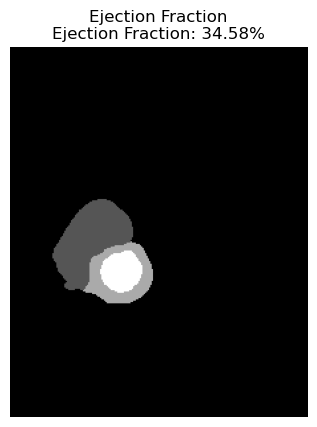

In [15]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label

def calculate_volume(image_slice, pixel_spacing, slice_thickness):
    """Calculate the volume of the segmented region."""
    area = np.sum(image_slice) * pixel_spacing**2  # Calculate area from segmented slice
    volume = area * slice_thickness  # Multiply by slice thickness to get the volume
    return volume

def process_mri(file_path, slice_index):
    """Process an MRI slice to calculate volume and return the segmented slice."""
    img = nib.load(file_path)
    data = img.get_fdata()
    pixel_spacing = img.header['pixdim'][1:3]  # Assuming pixel spacing is uniform in x and y
    slice_thickness = img.header['pixdim'][3]  # Slice thickness

    # Extract the specific slice based on provided index
    target_slice = data[:, :, slice_index]

    # thresholding
    segmented = target_slice > np.mean(target_slice)  # mean threshold

    volume = calculate_volume(segmented, pixel_spacing[0], slice_thickness)

    return volume, target_slice

def show_slice_with_ef(slice_data, ef, title):
    """Display the EF slice with Ejection Fraction information."""
    plt.imshow(slice_data, cmap='gray')
    plt.title(f"{title}\nEjection Fraction: {ef:.2f}%")
    plt.axis('off')
    plt.show()

# File paths
file_path = './unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_2/8_7_pred.nii.gz'

# Slice indices
ed_slice_index = 1  # end-diastolic slice index
es_slice_index = 5  # end-systolic slice index

# Process the file and calculate the EF
edv, ed_slice = process_mri(file_path, ed_slice_index)
esv, es_slice = process_mri(file_path, es_slice_index)
ef = ((edv - esv) / edv) * 100

print("EDV:", edv)
print("ESV:", esv)
print("Ejection Fraction (EF): {:.2f}%".format(ef))

# Visualize Ejection Fraction
show_slice_with_ef(ed_slice, ef, "Ejection Fraction")

### **Box plot from each patology**

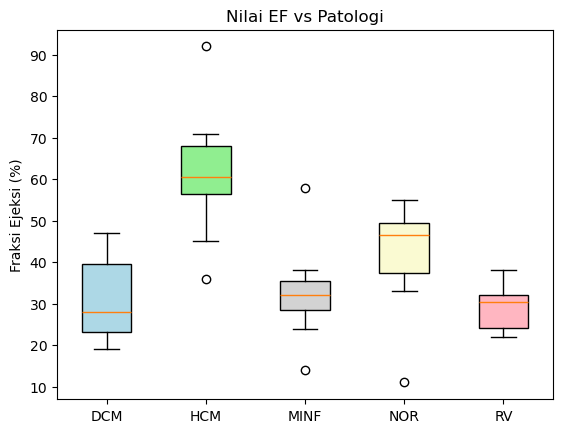

In [8]:
import matplotlib.pyplot as plt

# EF values for each category
ef_values = {
    "DCM": [19, 28, 22, 23, 47, 38, 41, 24, 40, 28],
    "HCM": [69, 56, 61, 65, 45, 60, 36, 71, 92, 58],
    "MINF":[30, 36, 34, 34, 28, 24, 38, 14, 30, 58],
    "NOR": [55, 47, 33, 48, 42, 51, 36, 11, 50, 46],
    "RV":  [30, 24, 31, 23, 38, 32, 34, 25, 22, 32]
}

# Colors for each box plot
colors = ['lightblue', 'lightgreen', 'lightgray', 'lightgoldenrodyellow', 'lightpink']

# Create a box plot for EF values
fig, ax = plt.subplots()
boxplots = ax.boxplot(ef_values.values(), vert=True, patch_artist=True)

# Set colors for each box
for patch, color in zip(boxplots['boxes'], colors):
    patch.set_facecolor(color)

# Set titles and labels
plt.title('Nilai EF vs Patologi')
plt.ylabel('Fraksi Ejeksi (%)')
plt.xticks([1, 2, 3, 4, 5], ef_values.keys())

# Show plot
plt.show()

## **3D Visualization**

In [1]:
import nibabel as nib

nifti_file_path = './unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_2/0_9_pred.nii.gz'
nifti_data = nib.load(nifti_file_path)
heart_data = nifti_data.get_fdata()

print(heart_data.shape)

(304, 336, 10)


In [2]:
import ipyvolume as ipv

def interactive_3d_plot(data):
    ipv.figure()
    vol = ipv.volshow(data, level=[0.2, 0.5, 0.8], opacity=0.03)  # Adjust
    ipv.show()

interactive_3d_plot(heart_data)

c:\Users\nuzul\.conda\envs\TugasAkhir\Lib\site-packages\ipyvolume\serialize.py:102: RuntimeWarning: invalid value encountered in cast
  subdata[..., i] = ((gradient[i][zindex] / 2.0 + 0.5) * 255).astype(np.uint8)


Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.2, max=1.0, step…

## **2D EF Estimation**

Data shape: (304, 336, 10)


C:\Users\nuzul\AppData\Local\Temp\ipykernel_12368\2477936694.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


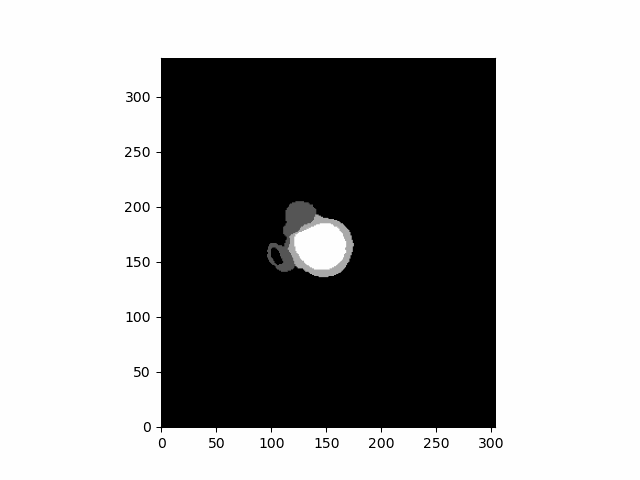

In [42]:
import nibabel as nib
import imageio
import matplotlib.pyplot as plt
import os
from IPython.display import Image

# Load the NIfTI file
nifti_file_path = './unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_2/0_9_pred.nii.gz'  # Adjust this to your file path
nifti_data = nib.load(nifti_file_path)
image_data = nifti_data.get_fdata()

# Check data shape to confirm dimensions
print("Data shape:", image_data.shape)

def save_slices_as_gif(image_data, axis=2, gif_path='nifti_slices.gif'):
    """Save all slices along a specified axis from a 3D NIfTI file as a GIF."""
    fig, ax = plt.subplots()
    ax.axis('off')  # Hide axes

    # Create a directory for temporary image files
    if not os.path.exists('temp_images'):
        os.makedirs('temp_images')

    # Process each slice
    filenames = []
    num_slices = image_data.shape[axis]
    for i in range(num_slices):
        ax.clear()  # Clear the previous slice
        if axis == 0:
            slice = image_data[i, :, :]
        elif axis == 1:
            slice = image_data[:, i, :]
        elif axis == 2:
            slice = image_data[:, :, i]

        # Show the slice
        ax.imshow(slice.T, cmap='gray', origin='lower')
        filename = f'temp_images/slice_{i:04d}.png'
        plt.savefig(filename)
        filenames.append(filename)

    # Compile the PNG files into a GIF with looping
    with imageio.get_writer(gif_path, mode='I', duration=0.1, loop=0) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

    # Cleanup temporary files
    for filename in filenames:
        os.remove(filename)
    os.rmdir('temp_images')
    plt.close()

    # Display the GIF in the notebook
    return Image(filename=gif_path)

# Call the function to create and display the GIF
Image_display = save_slices_as_gif(image_data, axis=2, gif_path='nifti_slices.gif')
Image_display

C:\Users\nuzul\AppData\Local\Temp\ipykernel_12368\2646352273.py:34: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


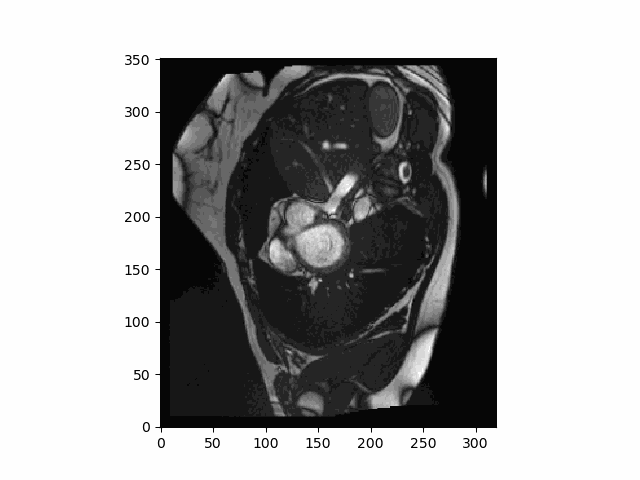

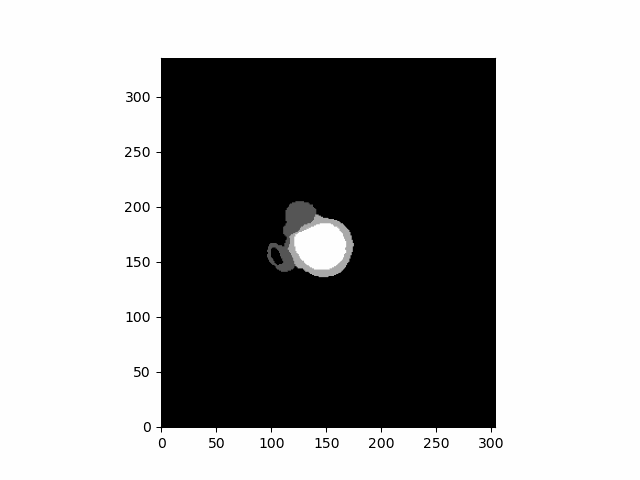

In [48]:
import nibabel as nib
import imageio
import matplotlib.pyplot as plt
import os
from IPython.display import Image, display

def create_gif_from_nifti(nifti_file_path, axis=2, gif_path='output.gif'):
    """Generate a GIF from slices of a NIfTI file along a specified axis."""
    nifti_data = nib.load(nifti_file_path)
    image_data = nifti_data.get_fdata()
    
    fig, ax = plt.subplots()
    ax.axis('off')  # Hide axes

    # Create a directory for temporary image files
    temp_dir = f"temp_images_{os.path.basename(gif_path).split('.')[0]}"
    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)

    # Process each slice
    filenames = []
    num_slices = image_data.shape[axis]
    for i in range(num_slices):
        ax.clear()  # Clear the previous slice
        slice = image_data.take(i, axis=axis)
        ax.imshow(slice.T, cmap='gray', origin='lower')
        filename = f'{temp_dir}/slice_{i:04d}.png'
        plt.savefig(filename)
        filenames.append(filename)

    # Compile the PNG files into a GIF with looping
    with imageio.get_writer(gif_path, mode='I', duration=0.1, loop=0) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

    # Cleanup temporary files
    for filename in filenames:
        os.remove(filename)
    os.rmdir(temp_dir)
    plt.close()
    
    return gif_path

# File paths for the two different NIfTI files
nifti_file_path1 = './unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_2/0_image.nii.gz'
nifti_file_path2 = './unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_2/0_9_pred.nii.gz'

# Generate GIFs for each file
gif_path1 = create_gif_from_nifti(nifti_file_path1, axis=2, gif_path='nifti1.gif')
gif_path2 = create_gif_from_nifti(nifti_file_path2, axis=2, gif_path='nifti2.gif')

# Display GIFs side by side
display(Image(filename=gif_path1))
display(Image(filename=gif_path2))

## **4D EF Estimation**
The 4D EF estimation is based on the 3D EF estimation. The 3D consist of x,y,z axis, and the 4th dimension represents spatio-temporal data with dimensions (x, y, z, t) where 't' is the temporal dimension, often representing different time points or frames.

In [12]:
import nibabel as nib
import ipyvolume as ipv
import ipywidgets as widgets
from IPython.display import display

# Load the 4D NIfTI file
nifti_file_path = './unet/test_results_3d/UNet3D_Attention_Best_0.5_Fold_2/0_9_pred.nii.gz'
nifti_data = nib.load(nifti_file_path)
heart_data = nifti_data.get_fdata()  # This should be 4D data

# Function to update the plot for a specific frame
def update_plot(frame_index):
    ipv.clear()
    data_slice = heart_data[:, :, :, frame_index]
    extent = [[0, heart_data.shape[0]], [0, heart_data.shape[1]], [0, heart_data.shape[2]]]
    vol = ipv.volshow(data_slice, level=[0.2, 0.5, 0.8], opacity=0.03, extent=extent)
    ipv.show()

# Create the slider
num_frames = heart_data.shape[-1]  # Assuming the last dimension is the time/frame dimension
frame_slider = widgets.IntSlider(min=0, max=num_frames-1, step=1, description='Frame')

# Link the slider to the update function
interactive_plot = widgets.interactive(update_plot, frame_index=frame_slider)

# Display the slider and the plot
display(frame_slider)
ipv.figure()
update_plot(0)  # Show the first frame by default
ipv.show()


IntSlider(value=0, description='Frame', max=9)

IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed